# RNN Twitter Disaster Classifier

## Imports

In [45]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing 
import itertools
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN
from tensorflow.keras.layers import Embedding
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Loading Data

In [ ]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

## Exploratory Data Analysis (EDA)

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.shape

(7613, 5)

There are 7613 tweets in the training data set with 5 associated fields for each tweet. As the aim of this work is to emphasize the utilization of recurrent neural networks on text classification, our focus will be on using the 'text' field to predict the 'target' field. A more robust model would make use of the other features in addition in a hybrid format but as already mentioned, modeling sequential text within a tweet is the aim here. A value of 1 in this field indicates that the tweet is about a real disaster. Determining which tweets are about disasters is the aim of the classifier.

In [6]:
np.mean(train['target'])

0.4296597924602653

Almost 43% of tweets are about a disaster. The data set is curated for the classification task as in reality the proportion of tweets fitting into this category would be substantially lower. Having nearly balanced data will allow for accuracy to be used as a reasonable metric, with models ranked on the test set by accuracy. 

In [7]:
np.array(train[train['target'] == 1]['text'])[:5]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '],
      dtype=object)

In [8]:
np.array(train[train['target'] == 0]['text'])[:5]

array(["What's up man?", 'I love fruits', 'Summer is lovely',
       'My car is so fast', 'What a goooooooaaaaaal!!!!!!'], dtype=object)

Above are the full text of five tweets that are about disasters and  below are five that are not. The above samples should be fairly easy to classify. 

Text(0, 0.5, 'Count')

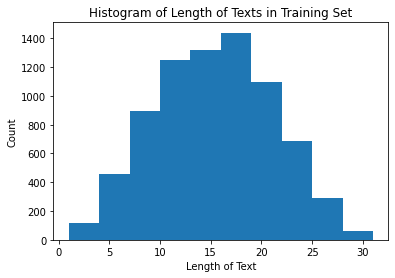

In [9]:
plt.hist([len(i.split()) for i in train['text']])
plt.title('Histogram of Length of Texts in Training Set')
plt.xlabel('Length of Text')
plt.ylabel('Count')

In [10]:
max(len(i.split()) for i in train['text'])

31

The tweets in this data set are most 31 words (by convention they have character limits) with most containing between 10 and 20 words. Relatively simple models should suffice given this. 

Text(0, 0.5, 'Count')

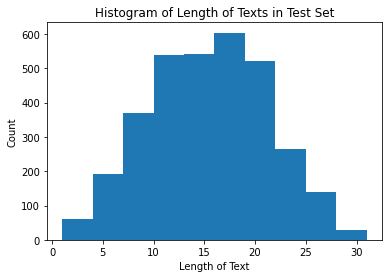

In [11]:
plt.hist([len(i.split()) for i in test['text']])
plt.title('Histogram of Length of Texts in Test Set')
plt.xlabel('Length of Text')
plt.ylabel('Count')

In [12]:
max(len(i.split()) for i in test['text'])

31

The distribution and maximum length in words of the text fields of the tweets are similar allowing for generalizability to be possible with a well constructed model. 

In [13]:
np.mean([len(i.split()) for i in train['text']])

14.903585971364771

In [14]:
np.mean([len(i.split()) for i in train[train['target'] == 1]['text']])

15.167532864567411

In [15]:
np.mean([len(i.split()) for i in train[train['target'] == 0]['text']])

14.704744357438969

Despite the initial samples of texts from both 'target' categories, overall the number of words in a tweet on average is similar for both those tweets about and not about disasters.

In [16]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [17]:
test.shape

(3263, 4)

There are slightly less than half as many tweets in the test set.

## Modeling

Among the many design choices for implementation that ultimately did not lead to the best results included using stop words combined with Tf-idf Vecotrizer parameter to remove words that did not sufficiently appear across tweets. When using recurrent neural networks, contextual meaning using all words, as opposed to reducing tweets to a subset of words, led to better performance. 

The tweets do need to be encoded into numerical vectors for the neural networks as done below.  

In [18]:
encoder = tf.keras.layers.TextVectorization()
encoder.adapt(train['text'])

In [19]:
len(encoder.get_vocabulary())

22699

There are over 20,000 distinct words in the training data set.

In [20]:
x = encoder(train['text']).numpy()

In [21]:
x.shape

(7613, 31)

In [22]:
np.max(x)

22698

Each unique word in the data set has been converted into an integer and each tweet is now a numerical vector.

In [23]:
max_review_length = x.shape[1]

In [24]:
y = train['target']

The validation split size was utilized as a hyperparameter in optimizing performance and was tuned with values from 0.1 to 0.5 tried with 0.3 achieving the best results. Given the large number of parameters in neural networks, appropriate care is needed to ensure overfitting to the training split does not occur.

In [25]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.3, random_state = 0)

Many hyperparameters were tuned in the model below to ensure that the complexity of the model was reasonable. GRUs, RNNs and LSTMs were tried with GRUs leading to the best results. The embedding vector length and number of recurrent units were adjusted to both larger and smaller values too than found below. The embedding layer in the network converts words to numerical vectors for neural network training. 

A handful of the many models attempted are presented in the notebook to present a common theme of overfitting to training (as will be seen in the subsequent accuracy and loss curves). Early stopping tied to optimal accuracy on the validation set (with weights restored) was paramount in mitigating overfitting with the hope of out of sample generalizability on the accuracy metric when fitting ont he test set. We first showcase the best performing model architecture.

A sigmoid activation function is used to convert the output to probabilities between 0 and 1 which is compared to the target in the calculation of binary cross-entropy loss.


In [26]:
embedding_vetcor_length = 4
input_dim = len(encoder.get_vocabulary())

# fix random seed for reproducibility
tf.random.set_seed(0)

model1 = Sequential()
model1.add(Embedding(input_dim, embedding_vetcor_length, input_length=max_review_length, mask_zero=True))
model1.add(GRU(4))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 4)             90796     
                                                                 
 gru (GRU)                   (None, 4)                 120       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 90,921
Trainable params: 90,921
Non-trainable params: 0
_________________________________________________________________


There are over 90,000 parameters in this model but this is mainly due to the embedding layer. This is even with the embedding vector length and number of recurrent units (GRUs) are both only 4.

In [27]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model1.fit(x_train, y_train, epochs=10, callbacks = [callback],
                    validation_data=(x_val, y_val))

Epoch 1/10
167/167 [==============================] - 10s 35ms/step - loss: 0.6828 - accuracy: 0.5603 - val_loss: 0.6646 - val_accuracy: 0.5858
Epoch 2/10
167/167 [==============================] - 5s 28ms/step - loss: 0.5836 - accuracy: 0.6938 - val_loss: 0.5019 - val_accuracy: 0.7877
Epoch 3/10
167/167 [==============================] - 5s 28ms/step - loss: 0.3531 - accuracy: 0.8707 - val_loss: 0.4709 - val_accuracy: 0.7977
Epoch 4/10
167/167 [==============================] - 4s 24ms/step - loss: 0.2154 - accuracy: 0.9283 - val_loss: 0.5173 - val_accuracy: 0.7697
Epoch 5/10
167/167 [==============================] - 4s 26ms/step - loss: 0.1441 - accuracy: 0.9578 - val_loss: 0.5324 - val_accuracy: 0.7802
Epoch 6/10
167/167 [==============================] - 3s 20ms/step - loss: 0.0969 - accuracy: 0.9730 - val_loss: 0.6233 - val_accuracy: 0.7640


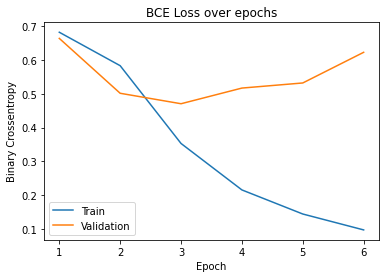

In [28]:
plt.plot(range(1,len(history.history['loss']) + 1), history.history['loss'])
plt.plot(range(1, len(history.history['loss']) + 1) , history.history['val_loss'])
plt.title('BCE Loss over epochs')
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

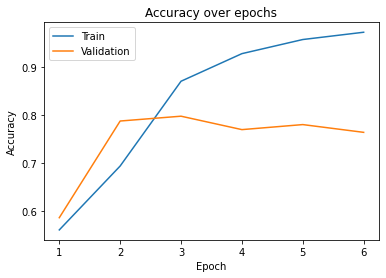

In [29]:
plt.plot(range(1,len(history.history['loss']) + 1), history.history['accuracy'])
plt.plot(range(1, len(history.history['loss']) + 1) , history.history['val_accuracy'])
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

As can be seen from the loss and accuracy curves, fitting to training continues to improve with so many parameters in the model. Early stopping tied to validation accuracy leads to only a few epochs of training being needed.

Fewer GRU units and a shorter embedding vector length is used below to reduce the number of parameters. 

In [30]:
tf.random.set_seed(0)
embedding_vetcor_length = 2
input_dim = len(encoder.get_vocabulary())
model2 = Sequential()
model2.add(Embedding(input_dim, embedding_vetcor_length, input_length=max_review_length, mask_zero=True))
model2.add(GRU(2))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 31, 2)             45398     
                                                                 
 gru_1 (GRU)                 (None, 2)                 36        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 45,437
Trainable params: 45,437
Non-trainable params: 0
_________________________________________________________________


The number of parameters is now about half of what it was in the previous model with again the embedding layer being prominent in this respect.

In [31]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model2.fit(x_train, y_train, epochs=10, callbacks = [callback], 
                    validation_data=(x_val, y_val))

Epoch 1/10
167/167 [==============================] - 9s 28ms/step - loss: 0.6873 - accuracy: 0.5579 - val_loss: 0.6787 - val_accuracy: 0.5858
Epoch 2/10
167/167 [==============================] - 4s 25ms/step - loss: 0.6734 - accuracy: 0.5637 - val_loss: 0.6649 - val_accuracy: 0.5858
Epoch 3/10
167/167 [==============================] - 5s 27ms/step - loss: 0.6233 - accuracy: 0.6331 - val_loss: 0.6155 - val_accuracy: 0.6835
Epoch 4/10
167/167 [==============================] - 3s 20ms/step - loss: 0.4574 - accuracy: 0.8514 - val_loss: 0.5022 - val_accuracy: 0.7758
Epoch 5/10
167/167 [==============================] - 3s 19ms/step - loss: 0.2870 - accuracy: 0.9020 - val_loss: 0.4888 - val_accuracy: 0.7793
Epoch 6/10
167/167 [==============================] - 3s 20ms/step - loss: 0.1964 - accuracy: 0.9388 - val_loss: 0.5050 - val_accuracy: 0.7736
Epoch 7/10
167/167 [==============================] - 3s 20ms/step - loss: 0.1415 - accuracy: 0.9610 - val_loss: 0.5427 - val_accuracy: 0.7588

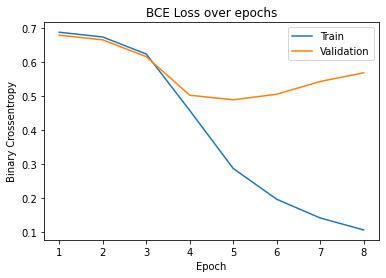

In [32]:
plt.plot(range(1,len(history.history['loss']) + 1), history.history['loss'])
plt.plot(range(1, len(history.history['loss']) + 1) , history.history['val_loss'])
plt.title('BCE Loss over epochs')
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

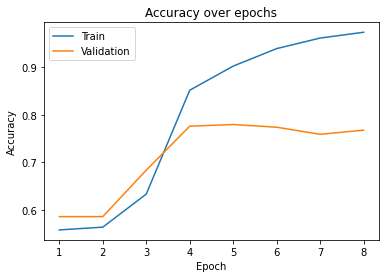

In [33]:
plt.plot(range(1,len(history.history['loss']) + 1), history.history['accuracy'])
plt.plot(range(1, len(history.history['loss']) + 1) , history.history['val_accuracy'])
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

 The loss and accuracy curves show a consistent pattern with potential overfitting being thwarted by the validation set with the metrics on the validation set peaking quickly.

Next LSTM units are instead of GRUs.

In [34]:
tf.random.set_seed(0)
embedding_vetcor_length = 4
input_dim = len(encoder.get_vocabulary())
model3 = Sequential()
model3.add(Embedding(input_dim, embedding_vetcor_length, input_length=max_review_length, mask_zero=True))
model3.add(LSTM(4))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 31, 4)             90796     
                                                                 
 lstm (LSTM)                 (None, 4)                 144       
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 90,945
Trainable params: 90,945
Non-trainable params: 0
_________________________________________________________________


The number of parameters is similar to the first model.

In [35]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model3.fit(x_train, y_train, epochs=10, callbacks = [callback], 
                    validation_data=(x_val, y_val))

Epoch 1/10
167/167 [==============================] - 11s 37ms/step - loss: 0.6714 - accuracy: 0.5808 - val_loss: 0.5995 - val_accuracy: 0.7128
Epoch 2/10
167/167 [==============================] - 5s 31ms/step - loss: 0.5138 - accuracy: 0.8135 - val_loss: 0.5089 - val_accuracy: 0.7780
Epoch 3/10
167/167 [==============================] - 4s 25ms/step - loss: 0.3559 - accuracy: 0.8887 - val_loss: 0.5013 - val_accuracy: 0.7850
Epoch 4/10
167/167 [==============================] - 4s 24ms/step - loss: 0.2569 - accuracy: 0.9264 - val_loss: 0.5269 - val_accuracy: 0.7732
Epoch 5/10
167/167 [==============================] - 5s 30ms/step - loss: 0.1953 - accuracy: 0.9456 - val_loss: 0.5531 - val_accuracy: 0.7701
Epoch 6/10
167/167 [==============================] - 5s 28ms/step - loss: 0.1476 - accuracy: 0.9636 - val_loss: 0.5956 - val_accuracy: 0.7649


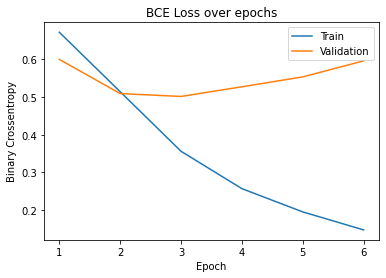

In [36]:
plt.plot(range(1,len(history.history['loss']) + 1), history.history['loss'])
plt.plot(range(1, len(history.history['loss']) + 1) , history.history['val_loss'])
plt.title('BCE Loss over epochs')
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

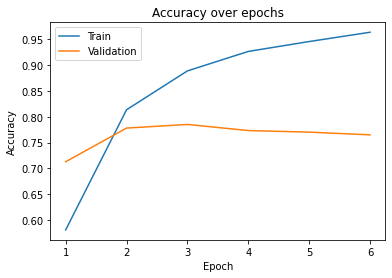

In [37]:
plt.plot(range(1,len(history.history['loss']) + 1), history.history['accuracy'])
plt.plot(range(1, len(history.history['loss']) + 1) , history.history['val_accuracy'])
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

The change in architecture does not have a substantial effect on the metrics presented in the graphs above.
 
The metrics using the restored best weights in each of the three models is summarized below.

|Model| BCE Loss (Train)| BCE Loss (Validation)|Accuracy (Train)| Accuracy (Validation)|
|:----|:----|:----|:----|:--------:|
|GRU 90,000+ parameters|0.3531|0.4709|0.8707|0.7977|
|GRU 45,000+ parameters|0.2870|0.4888|0.9020|0.7793|
|LSTM 90,000+ parameters|0.3559|0.5013|0.8887 |0.7850|

The most importance metric in the table above is accuracy on the validation set (4th column) as that is what needs to be maximized out of sample on the test set. 

Now the best performing model is used to make predictions. All three of the above made inference on the test set on Kaggle (with results to follow shortly), but the GRU with 90,000 parameters predictions will be further studied to provide additional insights.



In [38]:
test_vec = encoder(test['text']).numpy()

In [39]:
train_preds = np.round(model1.predict(x))
train_preds = [int(i) for i in train_preds]

238/238 [==============================] - 3s 4ms/step


In [40]:
np.mean(train_preds == train['target'])

0.8899251280704059

In [41]:
np.mean(train_preds)

0.4020753973466439

The model slightly underpredicts tweets about disasters on the data it has been fitted on.

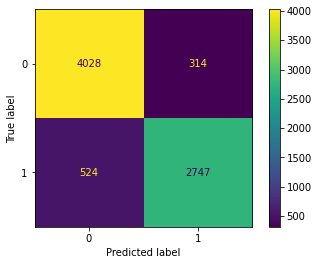

In [46]:
cm = confusion_matrix(train['target'], train_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format='')


The confusion matrix is presented as even though accuracy is the metric being employed to evaluate models, it may be the case that false positives and false negatives are not equally as problematic (depending on the use case of the classifier).





167/167 [==============================] - 1s 6ms/step


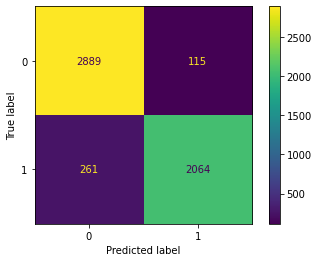

In [49]:
train_preds2 = np.round(model1.predict(x_train))
train_preds2 = [int(i) for i in train_preds2]

cm = confusion_matrix(y_train, train_preds2)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format='')

72/72 [==============================] - 1s 7ms/step


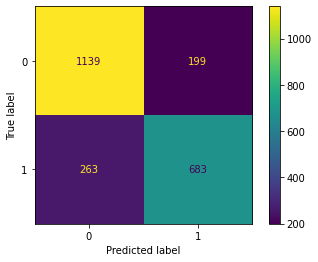

In [50]:
val_preds = np.round(model1.predict(x_val))
val_preds = [int(i) for i in val_preds]

cm = confusion_matrix(y_val, val_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format='')

Confusion matrices on the training and validation splits are also shown with the validation split (directly above) more likely tied to model performance out of sample.

Now we proceed ot the test set.

In [51]:
preds = np.round(model1.predict(test_vec))
preds = [int(i) for i in preds]

102/102 [==============================] - 0s 4ms/step


In [52]:
np.mean(preds)

0.363162733680662

On the test set the model predicts a still smaller percentage of tweets are about disasters.

In [ ]:
sub = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
sub['target'] = preds
sub.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [ ]:
sub.to_csv('submission.csv', index=False)

## Results Summary

|Model| Accuracy (Test)| 
|:----|:--------:|
|GRU 90,000+ parameters|0.78455|
|GRU 45,000+ parameters|0.76269|
|LSTM 90,000+ parameters|0.77229|

 
0.78455 accuracy was achieved on the test set upon submission of the apparently (per accuracy on the validation set) best model to Kaggle. This was the highest score achieved of the three and is quite close to its accuracy on the validation set. The other models also had only slightly lower accuracies in comparison to one another and with their own performance on the validation set.
 
However across models, as mentioned previously, the large number of embedding parameters led to overfitting on the training split. Perhaps dropout layers could mitigate this, or additional care in vectorizing the text is required. Direct attempts on lowering parameters via stop word and uncommon word removal did not work well with recurrent neural networks.
 
When the model parameters were reduced substantially, there still wasn't much improvement in out of sample loss and accuracy even if there was less overfitting on the training data. This suggests more nuanced NLP preprocessing techniques or combining the other tweet attributes in the data are avenues worthy of exploration.
 
